In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
rac = '../../neighborhoods_ccdistricts/data/raw/nyc_rac.csv'
rac_df = pd.read_csv(rac)

In [4]:
ct_shapefile = '../data/nyct2010_24d/nyct2010.shp'
ct_gdf = gpd.read_file(ct_shapefile)

In [5]:
jd = pd.read_csv('../../john_data/export_r.csv')
tc = pd.read_csv('../../neighborhoods_ccdistricts/data/raw/tract_check.csv')

In [6]:
jd = jd.merge(tc, left_on='tract20',right_on= 'GEOID', how='left')

In [157]:
jd[['tract20','GEOID_TRACT_10']].head()

,tract20,GEOID_TRACT_10
0,3.600500e+10,36005000100
1,3.600500e+10,36005000200
2,3.600500e+10,36005000400
3,3.600500e+10,36005001600
4,3.600500e+10,36005001900


In [7]:
cns_cols = rac_df.filter(regex='^cns').columns
ca_cols = rac_df.filter(regex='^ca').columns
ct_cols = rac_df.filter(regex='^ct').columns
ct_cols = ct_cols.drop(['cty', 'ctyname'])
cd_cols = rac_df.filter(regex='^cd').columns
cs_cols = rac_df.filter(regex='^cs').columns
cr_cols = rac_df.filter(regex='^cr').columns
cols_lists = [cns_cols, ca_cols, ct_cols, cd_cols, cs_cols,cr_cols]

In [45]:
ct_cols

Index(['ct01', 'ct02'], dtype='object')

In [8]:
for cols in cols_lists:
    rac_df[cols] = rac_df[cols].apply(pd.to_numeric, errors='coerce')

In [9]:
def make_pcts(df,col_list):
    for cols in col_list:
        for col in cols:
            df[col+'_pct'] = (df[col] / df['c000']) * 100
    return df

In [10]:
rac_df = make_pcts(rac_df,cols_lists)

In [11]:
pct_cols = rac_df.filter(regex='_pct').columns

In [12]:
trct_avg = rac_df.groupby('trct')[pct_cols].mean().reset_index()

In [58]:
trct_avg['trct'].sample(10)

670     36047039300
922     36047076600
600     36047030900
1504    36081015300
28      36005005200
648     36047036600
510     36047021700
2146    36085024401
1430    36081005900
1948    36081099701
Name: trct, dtype: int64

In [13]:
trct_avg = trct_avg.merge(jd, left_on='trct', right_on='GEOID_TRACT_10', how='left')

In [21]:
ct_gdf['CT2010'] = ct_gdf['CT2010'].astype(str).str.zfill(6)
trct_avg['tract_code'] = trct_avg['trct'].astype(str).str[-6:]
merged_df = ct_gdf.merge(trct_avg, left_on='CT2010', right_on='tract_code', how='left')

In [15]:
cns_pct_cols = merged_df.filter(regex='^cns').columns
cr_pct_cols = merged_df.filter(regex='^cr').columns
cd_pct_cols = merged_df.filter(regex='^cd').columns

In [16]:
cr_pct_cols = cr_pct_cols.append(pd.Index(['ct02_pct']))

In [17]:
merged_df['max_oc_col'] = merged_df[cns_pct_cols].idxmax(axis=1)
merged_df['max_race_col'] = merged_df[cr_pct_cols].idxmax(axis=1)

In [18]:
var_dict = {
    'cns01_pct':'Agriculture, Forestry, Fishing and Hunting',
    'cns02_pct':'Mining, Quarrying, and Oil and Gas Extraction',
    'cns03_pct':'Utilities',
    'cns04_pct':'Construction',
    'cns05_pct':'Manufacturing',
    'cns06_pct':'Wholesale Trade',
    'cns07_pct':'Retail Trade',
    'cns08_pct':'Transportation and Warehousing',
    'cns09_pct':'Information',
    'cns10_pct':'Finance and Insurance',
    'cns11_pct':'Real Estate and Rental and Leasing',
    'cns12_pct':'Professional, Scientific, and Technical Services',
    'cns13_pct':'Management of Companies and Enterprises',
    'cns14_pct':'Administrative and Support and Waste Management and Remediation Services',
    'cns15_pct':'Educational Services',
    'cns16_pct':'Health Care and Social Assistance',
    'cns17_pct':'Arts, Entertainment, and Recreation',
    'cns18_pct':'Accommodation and Food Services',
    'cns19_pct':'Other Services [except Public Administration]',
    'cns20_pct':'Public Administration'
}

In [19]:
racial_dict = {
    'cr01_pct':'White',
    'cr02_pct':'Black or African American',
    'cr03_pct':'American Indian or Alaska Native',
    'cr04_pct':'Asian',
    'cr05_pct':'Native Hawaiian or Other Pacific Islander',
    'cr07_pct':'Two or More',
    'ct02_pct':'Hispanic or Latino'
}

In [172]:
merged_df['max_oc_col_name'] = merged_df['max_oc_col'].map(var_dict)
merged_df['max_racial_col_name'] = merged_df['max_race_col'].map(racial_dict)

In [173]:
top_oc_names = ['Health Care and Social Assistance',
                'Educational Services',
                'Retail Trade',
                'Professional, Scientific, and Technical Services',
                'Accommodation and Food Services',
                'Wholesale Trade',
                'Finance and Insurance','Information']

In [176]:
merged_df[merged_df['max_oc_col_name'].isin(top_oc_names)][[ 'BoroName','NTAName','max_oc_col','max_oc_col_name','max_race_col','max_racial_col_name']].sample(10)

,BoroName,NTAName,max_oc_col,max_oc_col_name,max_race_col,max_racial_col_name
1715,Manhattan,Midtown-Midtown South,cns10_pct,Finance and Insurance,cr01_pct,White
4093,Bronx,Fordham South,cns16_pct,Health Care and Social Assistance,cr02_pct,Black or African American
3103,Queens,Pomonok-Flushing Heights-Hillcrest,cns16_pct,Health Care and Social Assistance,cr01_pct,White
1020,Queens,Bayside-Bayside Hills,cns16_pct,Health Care and Social Assistance,cr01_pct,White
173,Brooklyn,Bensonhurst West,cns16_pct,Health Care and Social Assistance,cr01_pct,White
2972,Manhattan,Lenox Hill-Roosevelt Island,cns16_pct,Health Care and Social Assistance,cr01_pct,White
1565,Staten Island,Stapleton-Rosebank,cns16_pct,Health Care and Social Assistance,cr04_pct,Asian
3716,Bronx,Spuyten Duyvil-Kingsbridge,cns16_pct,Health Care and Social Assistance,cr02_pct,Black or African American
968,Manhattan,Central Harlem North-Polo Grounds,cns16_pct,Health Care and Social Assistance,cr02_pct,Black or African American
3825,Manhattan,Lincoln Square,cns16_pct,Health Care and Social Assistance,cr01_pct,White


In [25]:
merged_df = merged_df.rename(columns=var_dict)

In [29]:
merged_df.to_csv('../data/occupation_demographics_ct.csv', index=False)

cluster

In [28]:
cols = []
for col in merged_df.columns:
    cols.append(col)

print(cols)

['CTLabel', 'BoroCode', 'BoroName', 'CT2010', 'BoroCT2010', 'CDEligibil', 'NTACode', 'NTAName', 'PUMA', 'Shape_Leng', 'Shape_Area', 'geometry', 'trct', 'Agriculture, Forestry, Fishing and Hunting', 'Mining, Quarrying, and Oil and Gas Extraction', 'Utilities', 'Construction', 'Manufacturing', 'Wholesale Trade', 'Retail Trade', 'Transportation and Warehousing', 'Information', 'Finance and Insurance', 'Real Estate and Rental and Leasing', 'Professional, Scientific, and Technical Services', 'Management of Companies and Enterprises', 'Administrative and Support and Waste Management and Remediation Services', 'Educational Services', 'Health Care and Social Assistance', 'Arts, Entertainment, and Recreation', 'Accommodation and Food Services', 'Other Services [except Public Administration]', 'Public Administration', 'ca01_pct', 'ca02_pct', 'ca03_pct', 'ct01_pct', 'ct02_pct', 'cd01_pct', 'cd02_pct', 'cd03_pct', 'cd04_pct', 'cs01_pct', 'cs02_pct', 'cr01_pct', 'cr02_pct', 'cr03_pct', 'cr04_pct', 

In [22]:
merged_df['dpp20bs'] = merged_df['dpp20bs'] / 10

In [23]:
cols_to_keep = ['trct','cns04_pct','cns05_pct','cns06_pct', 'cns07_pct','cns08_pct', 'cns09_pct', 'cns10_pct','cns12_pct', 'cns13_pct', 'cns15_pct', 'cns16_pct',
                 'cns17_pct', 'cns18_pct','h21p', 'nha21p', 'nhb21p', 'nhw21p',
                'mhhi21','cvap21bapp', 'dpp20bs',
                 'mex21p', 'prican21p', 'domin21p', 'colomb21p', 'kor21p', 'chin21p', 'venez21p',
                'drive_ratio', 'train_ratio', 'walk_ratio', 'bike_ratio', 'wfh_ratio', 'bus_ratio','hh21op']

In [13]:
job_cols = ['cns05_pct','cns06_pct', 'cns07_pct','cns08_pct', 'cns09_pct', 'cns10_pct','cns12_pct', 'cns13_pct', 'cns15_pct', 'cns16_pct','cns17_pct', 'cns18_pct']
race_cols = ['h21p', 'nha21p', 'nhb21p', 'nhw21p']

In [363]:
df = merged_df[cols_to_keep]
df = df.dropna()
features = df.drop(columns=['trct'])

In [364]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [365]:
# elbow method to determine number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Text(0.5, 0, 'Number of clusters')

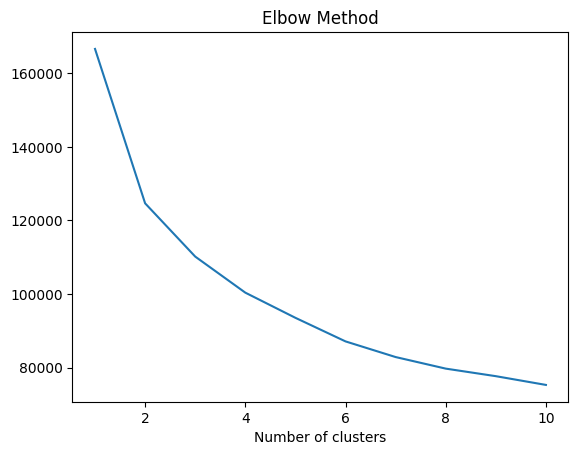

In [366]:
# plot the inertia values
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')

In [367]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(scaled_features)
df['cluster'] = kmeans.labels_

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [368]:
averages = df.groupby('cluster').mean().reset_index()

In [293]:
averages

,cluster,trct,cns04_pct,cns05_pct,cns06_pct,cns07_pct,cns08_pct,cns09_pct,cns10_pct,cns12_pct,...,cns16_pct,cns17_pct,cns18_pct,h21p,nha21p,nhb21p,nhw21p,mhhi21,cvap21bapp,dpp20bs
0,0,3.605775e+10,1.721661,1.642685,3.976206,6.304828,1.327062,9.131399,14.819261,16.701413,...,10.286538,2.912548,8.280145,11.116431,12.537746,4.692879,66.846425,147497.022191,77.848457,1.170860
1,1,3.603272e+10,4.058688,3.512282,3.995435,13.079533,3.992105,2.991699,4.274662,5.794063,...,22.865430,2.086705,10.756165,62.266804,6.047542,20.438238,8.192956,47664.412656,19.632473,0.718004
2,2,3.606829e+10,4.486499,4.270275,4.826527,12.090142,3.777205,3.193856,5.803805,7.376798,...,20.333505,1.711600,12.200192,25.139250,46.085286,5.108934,17.344417,69174.181957,32.405442,0.423089
3,3,3.606223e+10,5.356121,3.287596,5.045275,11.748320,3.303843,3.657192,6.780770,8.137186,...,22.021848,1.755352,8.116252,15.603589,14.206613,4.373486,62.805457,83571.408140,37.881818,0.322140
4,4,3.605368e+10,3.621692,2.428549,3.021972,12.046173,5.706120,2.929588,4.190787,5.153945,...,30.211353,1.681211,8.181761,15.851258,4.684307,68.164852,5.698095,70744.891185,25.785399,0.481061
5,5,3.605716e+10,3.137402,2.502413,3.787677,9.561756,2.561381,6.119238,7.637137,10.678937,...,16.137250,2.830273,10.512296,27.044262,10.043816,17.852962,40.553964,82072.567237,50.912528,1.532482


In [369]:
averages = averages.rename(columns=var_dict)

In [14]:
job_cols = ['Construction', 'Manufacturing', 'Wholesale Trade',
       'Retail Trade', 'Transportation and Warehousing', 'Information',
       'Finance and Insurance',
       'Professional, Scientific, and Technical Services',
       'Management of Companies and Enterprises', 'Educational Services',
       'Health Care and Social Assistance',
       'Arts, Entertainment, and Recreation',
       'Accommodation and Food Services']

In [372]:
averages['top_three'] = averages[job_cols].apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
averages['max_race_col'] = averages[race_cols].idxmax(axis=1)

In [268]:
averages['top_three'] = averages[job_cols].apply(lambda row: row.nlargest(3).index.tolist(), axis=1)

In [213]:
# change pd settings to display all text in a cell
pd.set_option('display.max_colwidth', None)

In [373]:
averages[['cluster','max_race_col','cvap21bapp','mhhi21', 'dpp20bs','Retail Trade','top_three']]

,cluster,max_race_col,cvap21bapp,mhhi21,dpp20bs,Retail Trade,top_three
0,0,nhb21p,25.724294,71570.641834,45.500000,12.056888,"[Health Care and Social Assistance, Retail Trade, Accommodation and Food Services]"
1,1,nhw21p,50.654643,81888.652068,147.517032,9.780369,"[Health Care and Social Assistance, Professional, Scientific, and Technical Services, Accommodation and Food Services]"
2,2,nhw21p,34.667784,82528.969190,32.790493,12.099672,"[Health Care and Social Assistance, Retail Trade, Accommodation and Food Services]"
3,3,h21p,19.350732,44580.353160,77.981413,13.057183,"[Health Care and Social Assistance, Retail Trade, Accommodation and Food Services]"
4,4,nhw21p,77.411501,146561.504723,118.210526,6.297033,"[Professional, Scientific, and Technical Services, Finance and Insurance, Health Care and Social Assistance]"
5,5,nha21p,35.362050,65046.908879,44.077103,11.407790,"[Health Care and Social Assistance, Accommodation and Food Services, Retail Trade]"


In [329]:
merged_df = merged_df.merge(df[['trct','cluster']], on='trct', how='left')

In [330]:
merged_df = merged_df.to_crs(epsg=4326)

In [331]:
merged_df['cluster'] = merged_df['cluster'].astype('category')

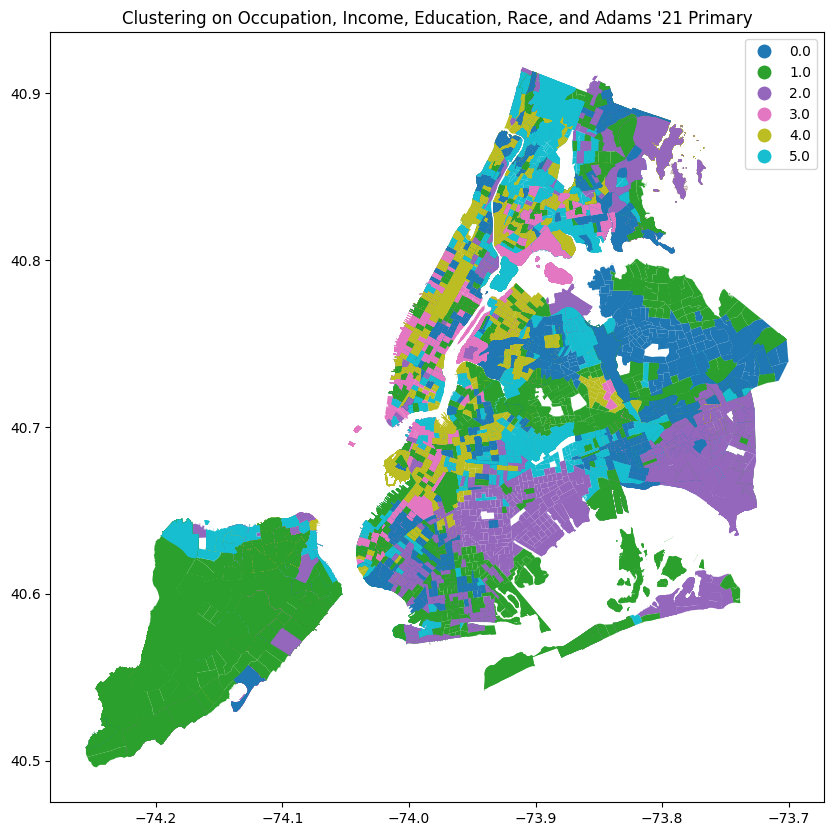

In [334]:
merged_df.plot(column='cluster', cmap='tab10', legend=True, figsize=(15, 10))
plt.title("Clustering on Occupation, Income, Education, Race, and Adams '21 Primary")
plt.show()

Will repeat the same clustering as above but with ED level data so that it can be joined with results.

In [6]:
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

In [9]:
ed_level.columns

Index(['ElectDist', 'Shape_Leng', 'Shape_Area', 'geometry', 'mhhi21',
       'Agriculture, Forestry, Fishing and Hunting',
       'Mining, Quarrying, and Oil and Gas Extraction', 'Utilities',
       'Construction', 'Manufacturing', 'Wholesale Trade', 'Retail Trade',
       'Transportation and Warehousing', 'Information',
       'Finance and Insurance', 'Real Estate and Rental and Leasing',
       'Professional, Scientific, and Technical Services',
       'Management of Companies and Enterprises',
       'Administrative and Support and Waste Management and Remediation Services',
       'Educational Services', 'Health Care and Social Assistance',
       'Arts, Entertainment, and Recreation',
       'Accommodation and Food Services',
       'Other Services [except Public Administration]',
       'Public Administration', 'nha21p', 'nhb21p', 'nhw21p', 'cvap21bapp'],
      dtype='object')

In [7]:
cols_to_keep = ['ElectDist','mhhi21','Construction', 'Manufacturing', 'Wholesale Trade', 'Retail Trade',
       'Transportation and Warehousing', 'Information',
       'Finance and Insurance', 'Real Estate and Rental and Leasing',
       'Professional, Scientific, and Technical Services',
       'Management of Companies and Enterprises',
       'Administrative and Support and Waste Management and Remediation Services',
       'Educational Services', 'Health Care and Social Assistance',
       'Arts, Entertainment, and Recreation',
       'Accommodation and Food Services',
       'Other Services [except Public Administration]',
       'Public Administration', 'nha21p', 'nhb21p', 'nhw21p', 'cvap21bapp']

In [8]:
df = ed_level[cols_to_keep]
df = df.dropna()
features = df.drop(columns=['ElectDist'])

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [13]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Text(0.5, 0, 'Number of clusters')

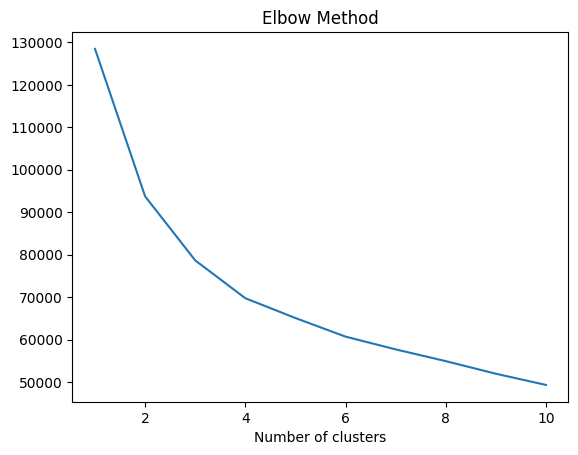

In [14]:
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')

In [10]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(scaled_features)
df['cluster'] = kmeans.labels_

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [11]:
averages = df.groupby('cluster').mean().reset_index()

In [15]:
averages['top_three'] = averages[job_cols].apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
averages['max_race_col'] = averages[race_cols].idxmax(axis=1)

KeyError: "['h21p'] not in index"